__Author:__ Bram Van de Sande

__Date:__ 28 FEB 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.utils import save_to_yaml
%matplotlib inline

### Phase Ib: Derive potential regulomes from these co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [3]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [4]:
len(df_modules)

4363616

In [5]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

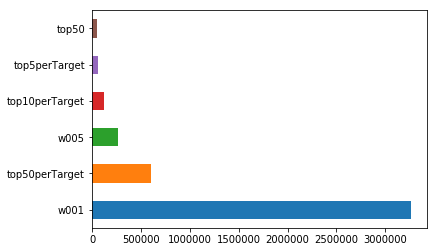

In [6]:
df_modules.method.value_counts().plot.barh()

In [7]:
df_modules[df_modules['TF'] == df_modules['target']]

,TF,target,importance,method


Compare the results with the modules derived by the R pipeline.

In [8]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [9]:
len(r_modules)

4363616

In [10]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [11]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [12]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [13]:
r_modules.equals(df_modules)

True

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

Testing of RcisTarget should start from exactly the same baseline. Modules for the python pipeline will therefore be created from the link lists with correlation information used in the R scripts.

In [14]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.regulome import prune_targets

In [15]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc8nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc8nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

#### Create modules from R datafile

In [16]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [17]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(genes_in_db))
    method2modules[method].append(regulome)

In [18]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [19]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

In [20]:
save_to_yaml(modules, os.path.join(RESOURCES_FOLDER, "modules_zeisel_2015.yaml"))

#### Create dataframe with enriched and TF-annotated motifs + leading edges

In [21]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [22]:
rnkdbs[0].load_full().shape

(20003, 22058)

In [23]:
from pyscenic.rnkdb import SQLiteRankingDatabase

In [24]:
sqldb = SQLiteRankingDatabase(os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc8nr.db"), '500bp', 'MGI')

In [25]:
sqldb.load_full().shape

(20003, 22058)

In [ ]:
df = derive_regulomes(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df",
                      client_or_address="custom_multiprocessing", num_workers=6)

__Potential causes of differences:__
1. _0-based rankings (python) versus 1-based rankings (R SCENIC version)?_ This has an effect on the interpretation of rank_cutoff. With 0-based the rank_cutoff is included while in 1-based systems this is not the cause. Both are correct calculations but just a difference in interpretation of the parameter. The normalization factor (maxAUC) should be corrected though.
```
aucThreshold <- round(aucMaxRank)
maxAUC <- aucThreshold * nrow(gSetRanks)
```
(According to this code snippet the maxAUC is calculated to take the aucThreshold into account while this is not the case for the current R implementation of the AUC calculation + 1-based rankings)
```
.auc <- function(oneRanking, aucThreshold, maxAUC)
{
  x <- oneRanking
  x <- sort(x[x<aucThreshold])

  y <- seq_along(x)
  sum(diff(c(x, aucThreshold)) * y)/maxAUC
}
```

However: the difference (when comparing ratios - cf. infra) this can introduce is marginal:

```
-> n-AUC/maxAUC//n-AUC/(maxAUC+1) ~ (n-AUC * (maxAUX+1))/(n-AUC * maxAUC) ~ (maxAUC+1)/maxAUC

-> constant for each gene signature.

-> maxAUC= nGenes * rank_cutoff (where rank_cutoff ~= 0.01 * 20K ~= 200 
-> minimum size of regulome is set at 20.
=> maximum difference is e.g. (20 * 200 + 1)/(20 * 200) = 1,00025!
```


2. _NES threshold (3.0)_. Exactly the same for both pipeline.
3. _Digits for truncation of NES and AUC values (3)_. Is available in the R version of the pipeline. This should have no effect on the calculations as this is only used for creating the final results table.
4. _Rank threshold (5000)_. Is exactly the same. Can only have an effect on the LE calculation. Has no effect on AUC calculations.
5. _AUC fraction (0.01)_. Is used to calculate the rank cutoff. Is the same between both pipelines. However the way the AUC cutoff is calculated in the R implementation was different because it is rounded while in the python implementation it was floored. The difference is corrected __RERUN required__

```
.AUC.geneSet <- function(geneSet, rankings, aucMaxRank, gSetName="")
{
  geneSet <- unique(geneSet)
  nGenes <- length(geneSet)
  geneSet <- geneSet[which(geneSet %in% rownames(rankings))]
  missing <- nGenes-length(geneSet)

  # gene names are no longer needed
  gSetRanks <- rankings[geneSet,]
  rm(rankings)

  aucThreshold <- round(aucMaxRank)
  maxAUC <- aucThreshold * nrow(gSetRanks)

  auc <- apply(gSetRanks, 2, .auc, aucThreshold, maxAUC)

  c(auc, missing=missing, nGenes=nGenes)
}

```

6. _Minimum orthologous identity and maximum motif similarity FDR_: effect can be assessed in the results table from the python pipeline. But currently the R-based pipeline differentiates only two levels: directly annotated (direct or through orthologous identity) + inferred annotations through motif similarity.
7. _Ranking databases (500bp-upstream and 10kp-centered-arount-tss; both 20k features, i.e. version 8)_. Should be the same.
__But:__ 20,003 in python (feather) while according to documentation for R version there should be 20,004 features (https://htmlpreview.github.io/?https://github.com/aertslab/SCENIC/blob/master/inst/doc/Step2_Regulons.html).
8. _Some gene signatures are removed before NES calculation_: If more than 80% of genes of a signatures are missing. This signature is skipped. This should not affect the AUC calculation at all because AUC is calculated across features for the same signature only. This is now also part of the pySCENIC implementation.

```
if(all(missingPercent>=.80))
    stop("Fewer than 20% of the genes in the gene sets",
         " are included in the rankings.",
         "Check wether the gene IDs in the 'rankings' and 'geneSets' match.")

  if(any(missingPercent>.80))
  {
    warning("The following gene sets will be excluded from the analysis",
            "(less than 20% of their genes are available):\n",
            paste(names(missingPercent)[which(missingPercent >= .80)],
                  collapse=", "),
            immediate.=TRUE)
    aucMatrix <- aucMatrix[which(missingPercent < .80),,drop=FALSE]
  }
```

In [ ]:
len(df)

In [ ]:
df.head()

There are far less regulomes when using the python pipeline.

In [ ]:
df.index.get_level_values('TF').unique()

In [ ]:
df.index.get_level_values('TF').unique().values

Compare the top 5 results documented in the tutorial.

In [ ]:
df[df.index.get_level_values('TF') == 'Rfx3'].sort_values(by=('Enrichment', 'NES'), ascending=False)

Save to disk.

In [ ]:
df.to_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"))

In [26]:
df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)
len(df)

22013

### Compare enriched motifs with results from R pipeline.

Load R table of enriched motifs and convert it to a comparable format.

In [97]:
r_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.4_motifEnrichment_selfMotifs.txt"))
len(r_df)

11558

In [98]:
r_df.sort_values(by='NES', ascending=False).sort_values(by=['highlightedTFs']).head(3)

,Unnamed: 0,motifDb,geneSet,motif,NES,AUC,highlightedTFs,TFinDB,TF_direct,TF_inferred
1,2,500bp,Acaa1b_top50,transfac_pro__M04671,4.28,0.0733,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
0,1,500bp,Acaa1b_top50,transfac_pro__M01543,4.39,0.0749,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
2,3,500bp,Ahr_w001,transfac_pro__M00778,3.22,0.0131,Ahr,**,Ahr,NaN


In [99]:
r_df = r_df.rename(columns={'motifDb': 'DbId', 'geneSet': 'ModuleType', 'motif': 'MotifID', 'highlightedTFs': 'TF'})
COLUMNS = ['DbId', 'ModuleType', 'MotifID', 'TF', 'AUC', 'NES']
r_df = r_df[COLUMNS]
r_df['ModuleType'] = r_df['ModuleType'].apply(lambda s: s.split("_")[1])
r_df.head(3)

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.0749,4.39
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.0733,4.28
2,500bp,w001,transfac_pro__M00778,Ahr,0.0131,3.22


Load python table of enriched motifs and convert it to a comparable format.

In [111]:
py_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)
len(py_df)

22013

In [112]:
py_df.sort_values(by=[('Enrichment', 'NES')], ascending=False).sort_index(level=0).head(3)

Enrichment                                  \
                         AUC       NES MotifSimilarityQvalue   
TF    MotifID                                                  
Abcf2 hdpi__ABCF2   0.023643  2.691416                   0.0   
      hdpi__ABCF2   0.024249  2.546799                   0.0   
      hdpi__ABCF2   0.021493  2.514265                   0.0   

                                       \
                  OrthologousIdentity   
TF    MotifID                           
Abcf2 hdpi__ABCF2            0.982484   
      hdpi__ABCF2            0.982484   
      hdpi__ABCF2            0.982484   

                                                                      \
                                                          Annotation   
TF    MotifID                                                          
Abcf2 hdpi__ABCF2  gene is orthologous to ENSG00000033050 in H. s...   
      hdpi__ABCF2  gene is orthologous to ENSG00000033050 in H. s...   
      hdpi__ABCF2  gene is orthologous to ENSG00000033050 in H. s...   

                                                                      \
                                                             Context   
TF    MotifID                                                          
Abcf2 hdpi__ABCF2  frozenset({'mm9-tss-centered-10kb-10species', ...   
      hdpi__ABCF2  frozenset({'w005', 'mm9-tss-centered-10kb-10sp...   
      hdpi__ABCF2  frozenset({'top50', 'mm9-tss-centered-10kb-10s...   

                                      
                         TargetGenes  
TF    MotifID                         
Abcf2 hdpi__ABCF2  [('Morc2b', 1.0)]  
      hdpi__ABCF2  [('Morc2b', 1.0)]  
      hdpi__ABCF2  [('Morc2b', 1.0)]

In [113]:
py_df.columns = py_df.columns.droplevel(0)
py_df = py_df.reset_index()
DB_MAP = {
    'mm9-500bp-upstream-10species': '500bp',
    'mm9-tss-centered-10kb-10species': '10kbp'
}
def getdb(s):
    for elem in eval(s):
        if elem in DB_MAP:
            return DB_MAP[elem]
    raise ValueError
def getmodule(s):
    for elem in eval(s):
        if elem not in DB_MAP:
            return elem
    raise ValueError
py_df['DbId'] = py_df['Context'].apply(getdb)
py_df['ModuleType'] = py_df['Context'].apply(getmodule)
py_df = py_df[COLUMNS]
# Remove elements with NES < 3.0 ! The calculations for the python pipeline had a different NES score for investigating purposes.
py_df = py_df[py_df['NES'] >= 3.0]

In [114]:
py_df.head(3)

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.076018,4.853421
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.075656,4.827692
3,500bp,top50,homer__CCAGGAACAG_AR-halfsite,Ar,0.050405,7.587771


In [115]:
COMMON=['TF', 'MotifID', 'DbId', 'ModuleType']
c_df = pd.merge(r_df, py_df, left_on=COMMON, right_on=COMMON, suffixes=['_R', '_python'])

Comparison of AUC values in a scatter plot.

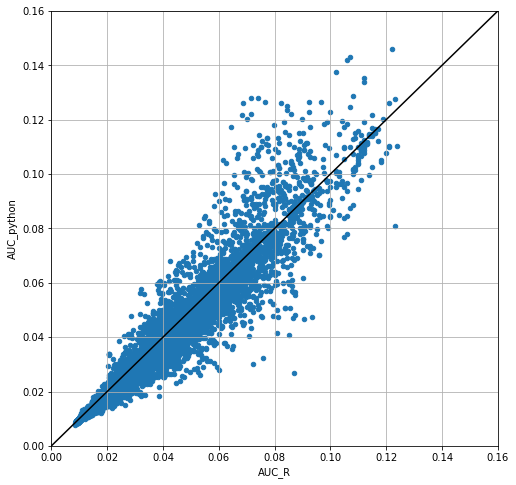

In [116]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='AUC_R', y='AUC_python', grid=True, ax=ax)
plt.xlim([0, 0.16])
plt.ylim([0, 0.16])
import matplotlib.pyplot as plt
plt.plot([0, 0.16], [0, 0.16], 'k-')

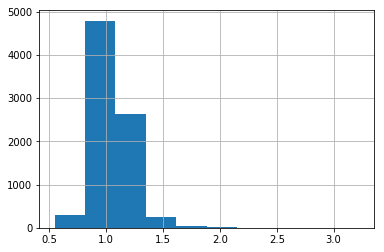

In [178]:
(c_df['AUC_R']/c_df['AUC_python']).hist()

In [183]:
(c_df['AUC_R']/c_df['AUC_python']).describe()

count    8004.000000
mean        1.058801
std         0.149359
min         0.545338
25%         0.989066
50%         1.042555
75%         1.121826
max         3.222402
dtype: float64

In [182]:
c_df[((c_df['AUC_R']/c_df['AUC_python']) <= 1.01) & ((c_df['AUC_R']/c_df['AUC_python']) >= 0.99)]

,DbId,ModuleType,MotifID,TF,AUC_R,NES_R,AUC_python,NES_python
60,500bp,top50,tfdimers__MD00257,Atf1,0.04330,3.28,0.043282,3.510323
79,500bp,top50,cisbp__M3090,Atf2,0.05940,5.33,0.059711,5.785257
81,500bp,top50,cisbp__M5302,Atf2,0.05740,5.13,0.057227,5.517165
82,500bp,top50,transfac_public__M00178,Atf2,0.05720,5.11,0.057581,5.555463
88,500bp,top50,transfac_pro__M07686,Atf2,0.05310,4.70,0.052702,5.028854
91,500bp,top50,transfac_pro__M07668,Atf2,0.05220,4.60,0.052169,4.971406
94,500bp,top50,transfac_pro__M07666,Atf2,0.05200,4.58,0.052081,4.961831
101,500bp,top50,cisbp__M6152,Atf2,0.05010,4.40,0.049862,4.722463
103,500bp,top50,taipale__ATF7_DBD_NNATGACGTCATNN_repr,Atf2,0.04960,4.34,0.049153,4.645865
124,500bp,top50,transfac_pro__M00917,Atf2,0.04650,4.03,0.046047,4.310750


Comparison of NES values in a scatter plot.

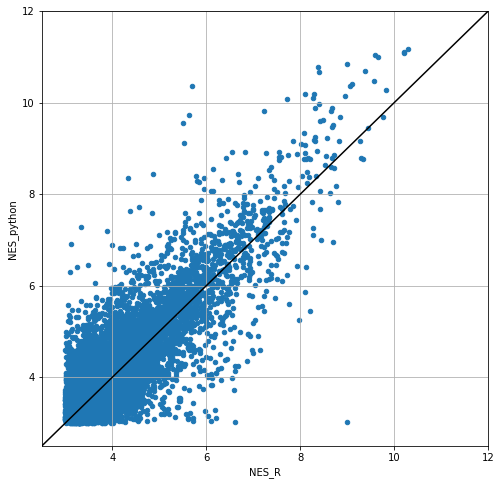

In [118]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='NES_R', y='NES_python', ax=ax, grid=True)
plt.xlim([2.5, 12])
plt.ylim([2.5, 12])
plt.plot([2.5, 12], [2.5, 12], 'k-')

#### Creation of regulomes

Create regulomes for python pipeline.

In [119]:
from pyscenic.regulome import df2regulomes

In [120]:
py_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)

In [121]:
py_df[('Enrichment', 'TargetGenes')] = list(map(eval, py_df[('Enrichment', 'TargetGenes')]))

Remove elements with NES < 3.0 ! The calculations for the python pipeline had a different NES score for investigating purposes.

In [122]:
py_df = py_df[py_df[('Enrichment', 'NES')] >= 3.0]

In [123]:
regulomes = df2regulomes(py_df, "MGI")

In [124]:
len(regulomes)

400

In [125]:
py_name2targets = {r.transcription_factor: set(r.genes) for r in regulomes}

In [126]:
len(py_name2targets)

400

Create regulomes for R pipeline.

In [128]:
r_incidences = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.6_regulons_asIncidMat.txt"), index_col=0)

In [129]:
r_incidences.shape

(554, 11336)

In [130]:
from matplotlib_venn import venn2

In [131]:
r_extended = set(map(lambda n: n.split('_')[0], filter(lambda n: n.endswith('_extended'), r_incidences.index)))

In [132]:
r_not_extended = set(filter(lambda n: not n.endswith('_extended'), r_incidences.index))

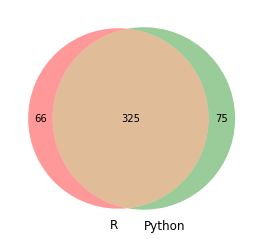

In [133]:
from operator import attrgetter
r_names = r_extended.union(r_not_extended)
py_names = set(map(attrgetter('name'), regulomes))
n_intersect = len(r_names.intersection(py_names))
venn2(subsets = (len(r_names)-n_intersect, len(py_names)-n_intersect, n_intersect), set_labels=('R', 'Python'))

More python regulomes can be explained by the fact that we could have been more resilient with the motif2TF parameters.

In [134]:
r_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if not tf.endswith("_extended")}

R version makes a difference between extended and not extended target genes (from derived motifs). In this notebook the regulomes derived from the dataframe take into account both target genes. We take this into account when comparing.

In [135]:
from cytoolz import merge_with

def union(args):
    if len(args) == 1:
        return args[0]
    return args[0].union(args[1])

tmp_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if tf.endswith("_extended")}
r_name2targets_extended = merge_with(union, r_name2targets, tmp_name2targets)

In [136]:
len(r_name2targets_extended)

391

In [137]:
len(r_name2targets)

318

Compare actual content of the intersecting regulomes via Jaccard Index.

Text(0.5,1,'Distribution of Jaccard Index')

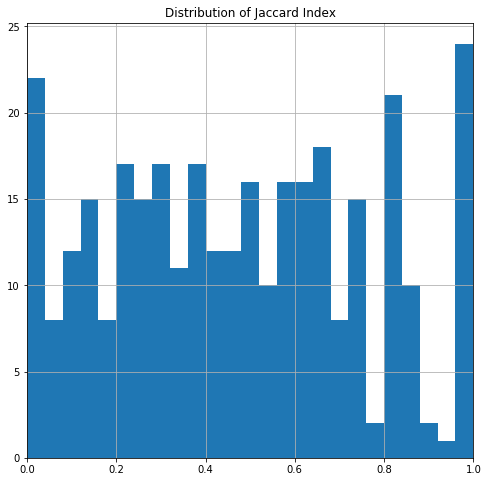

In [138]:
names = set(r_name2targets_extended.keys()).intersection(set(py_name2targets))
n = len(names)
def jaccard(s1, s2):
    return float(len(s1.intersection(s2)))/len(s1.union(s2))
fig, ax = plt.subplots(figsize=(8,8))
ji = pd.DataFrame(data={'JI': list(jaccard(r_name2targets_extended[name], py_name2targets[name]) for name in names)},
                  index=names)
ji.hist(bins=25, ax=ax)
plt.xlim([0, 1.0])
plt.title('Distribution of Jaccard Index')

Scrutinize the regulomes that have a JI of 0.0

In [142]:
py_df.columns = py_df.columns.droplevel(0)
py_df = py_df.reset_index()
DB_MAP = {
    'mm9-500bp-upstream-10species': '500bp',
    'mm9-tss-centered-10kb-10species': '10kbp'
}
def getdb(s):
    for elem in eval(s):
        if elem in DB_MAP:
            return DB_MAP[elem]
    raise ValueError
def getmodule(s):
    for elem in eval(s):
        if elem not in DB_MAP:
            return elem
    raise ValueError
py_df['DbId'] = py_df['Context'].apply(getdb)
py_df['ModuleType'] = py_df['Context'].apply(getmodule)
py_df = py_df[COLUMNS]

In [165]:
c_ji = ji.merge(c_df[['TF', 'NES_python']].groupby(by='TF').mean(), 
         left_index=True, right_index=True).merge(c_df[['TF', 'NES_R']].groupby(by='TF').mean(),
         left_index=True, right_index=True).merge(py_df[['TF', 'MotifID']].groupby(by='TF').count(),
         left_index=True, right_index=True).merge(r_df[['TF', 'MotifID']].groupby(by='TF').count(), suffixes=['_python', '_R'],
         left_index=True, right_index=True).sort_values(by='JI')
c_ji.head(5)

,JI,NES_python,NES_R,MotifID_python,MotifID_R
Bcl6b,0.019512,5.214115,3.080,3,23
Crem,0.019663,4.321536,3.510,32,3
Zfp449,0.020202,6.163822,6.385,2,6
Klf13,0.020748,3.992778,3.595,19,17
Gmeb2,0.024024,3.262271,4.660,1,5


Is there a correlation between JI and NES score?

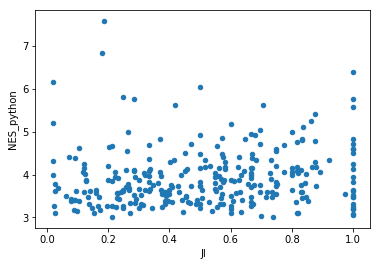

In [153]:
c_ji.plot.scatter(x='JI', y='NES_python')

What is the explanation of the extremely low JIs? Disjoint set of enriched motifs between R and python pipeline can only be a reasonable explanation.

In [155]:
py_df[py_df['TF'] == 'Bcl6b']

,DbId,ModuleType,MotifID,TF,AUC,NES
6291,10kbp,top50,taipale__BCL6B_DBD_TGCTTTCTAGGAATTMM_repr,Bcl6b,0.037919,5.207370
6292,10kbp,top50,c2h2_zfs__M4447,Bcl6b,0.038009,5.220861
12924,10kbp,top5perTarget,taipale__BCL6B_DBD_TGCTTTCTAGGAATTMM_repr,Bcl6b,0.037462,3.616820


In [156]:
r_df[r_df['TF'] == 'Bcl6b']

,DbId,ModuleType,MotifID,TF,AUC,NES
444,500bp,top10perTarget,cisbp__M1882,Bcl6b,0.0360,4.07
445,500bp,top10perTarget,jaspar__MA0050.2,Bcl6b,0.0325,3.58
446,500bp,top10perTarget,transfac_pro__M04788,Bcl6b,0.0298,3.21
447,500bp,top10perTarget,transfac_pro__M01882,Bcl6b,0.0296,3.18
448,500bp,top10perTarget,cisbp__M5576,Bcl6b,0.0293,3.14
449,500bp,top50perTarget,cisbp__M6312,Bcl6b,0.0209,3.60
450,500bp,top50perTarget,homer__GAAASYGAAASY_IRF2,Bcl6b,0.0205,3.51
451,500bp,top50perTarget,hocomoco__IRF7_HUMAN.H10MO.C,Bcl6b,0.0205,3.51
452,500bp,top50perTarget,cisbp__M1882,Bcl6b,0.0194,3.24
453,500bp,top50perTarget,cisbp__M6308,Bcl6b,0.0187,3.06


In [168]:
c_ji['motif_diff'] = (c_ji['MotifID_python'] - c_ji['MotifID_R']).abs()

In [169]:
c_ji.head()

,JI,NES_python,NES_R,MotifID_python,MotifID_R,motif_diff
Bcl6b,0.019512,5.214115,3.080,3,23,20
Crem,0.019663,4.321536,3.510,32,3,29
Zfp449,0.020202,6.163822,6.385,2,6,4
Klf13,0.020748,3.992778,3.595,19,17,2
Gmeb2,0.024024,3.262271,4.660,1,5,4


(0, 50)

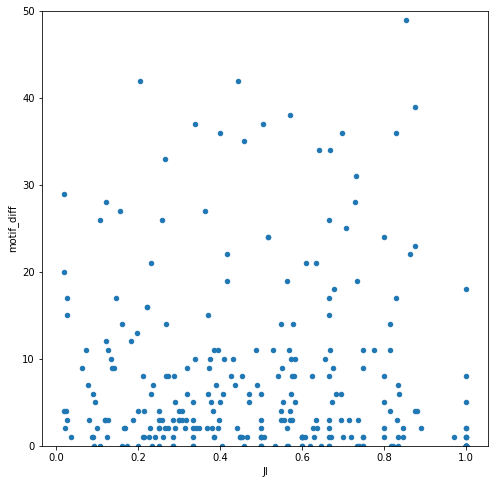

In [172]:
fig, ax = plt.subplots(figsize=(8,8))
c_ji.plot.scatter(x='JI', y='motif_diff', ax=ax)
plt.ylim([0, 50])

No real correlation can be explained by the fact that the actual metric to compare with JI is the disjointness of the two feature spaces.

Look at the enriched motifs for regulomes that have a JI of 1.0.

In [173]:
c_ji[c_ji['JI'] == 1.0]

,JI,NES_python,NES_R,MotifID_python,MotifID_R,motif_diff
Foxo6,1.0,3.199249,3.190000,1,1,0
Rara,1.0,3.630141,3.820000,4,3,1
Mxd4,1.0,4.597123,3.870000,12,4,8
Zfp652,1.0,6.387877,5.985000,2,2,0
Bbx,1.0,3.609076,3.648000,5,5,0
Polr3a,1.0,3.253137,3.495000,2,2,0
Zfp382,1.0,5.755805,4.290000,1,1,0
Dazap1,1.0,5.577406,5.900000,1,2,1
Scrt1,1.0,4.129229,3.648750,10,8,2
Rreb1,1.0,4.253669,4.011765,18,23,5


Experiment to validate this: create regulomes in python only based on motifs also found in R.

Does filtering on length of the regulome mitigate the problem? It should.

__Explanation of differences in LE__:
1. The R implementation uses an approx method to calculate the avg + 2 std RCC.
2. Different enriched motids are discovered for same TFs. This results in very different target genes.

In [175]:
c_ji.describe()

,JI,NES_python,NES_R,MotifID_python,MotifID_R,motif_diff
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,0.510515,3.923084,3.840111,44.641379,38.758621,11.641379
std,0.274126,0.672819,0.607853,90.205469,80.234844,23.807526
min,0.019512,3.000282,3.010000,1.000000,1.000000,0.000000
25%,0.285714,3.469584,3.419180,4.000000,3.000000,1.000000
50%,0.502995,3.759976,3.697868,11.000000,9.000000,4.000000
75%,0.718894,4.170966,4.108500,37.750000,28.750000,11.000000
max,1.000000,7.587771,7.210000,601.000000,628.000000,255.000000


__CONCLUSION:__ There is snowball effect: differences in AUC => differences in NES => differences in enriched motifs => differences in target genes.

Plan of action:
1. Check AUC calculation:

1.1. Implementation seems to be OK. Unittests + exact code match.

1.2. Input modules are exactly the same, i.e. derived from the R dataset and same statistics.

1.3. Is the database the same? 